In [4]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
# import warnings
# warnings.filterwarnings('ignore')

## Defining Logistic regresion functions

In [5]:
def sigmoid_func(z):
    '''
    A function to return sigmoid values between 0 to 1
    clipping is done to avoid 0 and 1 as output, because 0 and 1 will 
    result in Inf and NAN while calculating cost function
    '''
    p = 1/(1+ np.exp(-z))
    p = np.clip(p, a_min = 0.01, a_max = 0.99)
    return p

In [6]:
def cost_function(Y, p):
    '''
    This funtion calculates the mean loss using the
    cost function defined for logistic regression
    '''
    logp = np.log(p)
    log_1_minus_p = np.log(1 - p)
    part1 = np.multiply(Y, logp)
    part2 = np.multiply((1-Y), log_1_minus_p )
    cost = np.negative(np.mean([part1, part2]))
    return cost

In [7]:
def split_data(X, Y, test_size, valid_size, seed = 42):
    '''
    This function splits data into train test and validation data.
    The default seed is set to 42.
    The split is a stratified one, where the proportion of target values in train, 
    test and validation set is maintained
    '''

    # train and test split
    X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, 
                                                    random_state=seed, stratify=Y)
    # validation split
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size= valid_size,
                                                    random_state = seed, stratify = Y_train)
    return X_train, Y_train, X_test, Y_test, X_valid, Y_valid

In [8]:
def get_predictions(w, b, X, threshold = 0.5):
    pred = np.dot(w.T, X) + b
    pred_prob = sigmoid_func(pred)
    preds = [1 if i > threshold else 0 for i in pred_prob[0] ]
    return preds, pred_prob

In [9]:
def run_log_regression(X, Y, w, b, X_valid, Y_valid,learning_rate, threshold = 0.5):
    '''
    Trains the model using the data set, random weights, bias and learning rate as paramters
    '''
    # calculating z using which is dot product of weights and features plus a bias
    z = np.dot(w.T, X) + b
    # calculating the sigmoid 
    p = sigmoid_func(z)
    cost_this_epoch = cost_function(Y, p)
    loss = cost_this_epoch
    # calculate gradient and change of weights
    gradient = (p - Y )
    change_weights = (1/X.shape[1]) * np.dot(X, gradient.T)
    change_bias = (1/X.shape[1]) * np.sum(gradient)
    # Update weights and bias
    w = w - learning_rate*(change_weights)
    b = b - learning_rate*(change_bias)
    preds_valid, prob_valid = get_predictions(w, b, X_valid, threshold)
    loss_valid = cost_function(Y_valid, prob_valid)
    return w, b, loss, loss_valid

In [10]:
def search_parameters(X_train, Y_train, X_valid, Y_valid, lrs, print_report = False):
    for lr in lrs:
        # Initializing w and b :
        # Here w is initialised using randomly picked values from a normal distribution
        # whose mean is 0 and std is 2
        print("### For Learning Rate ", lr)
        np.random.seed(42)
        w = np.random.normal(0, 2,(X_train.shape[0],1))
        b = 0
        # training  for 50000 epochs with a learning rate of 0.1
        total_epochs = 50000
        learning_rate = lr
        costs = []
        costs_validation = []
        for i in range(total_epochs):
            w,b, cost_this_epoch, loss_valid = run_log_regression(X_train, Y_train, w, b, X_valid, Y_valid,learning_rate, threshold = 0.5)
            costs.append(cost_this_epoch)
            costs_validation.append(loss_valid)
        plt.plot(costs, label = 'train ')
        plt.plot(costs_validation, label = 'validation')
        plt.legend(loc = "upper right")
        plt.show()
        if print_report == True:
            preds_train, prob_train = get_predictions(w, b, X_train, threshold = 0.5)
            print('Train report')
            print(classification_report(Y_train.T, preds_train))
            preds_valid, prob_valid = get_predictions(w, b, X_valid, threshold = 0.5)
            print('validation report')
            print(classification_report(Y_valid.T, preds_valid))

In [11]:
def remove_outliers(data, column_name):
    '''function to remove outliers'''
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (data[column_name] >= Q1 - 1.5 * IQR) & (data[column_name] <= Q3 + 1.5 *IQR)
    new_data = data.loc[filter]  
    new_data.reset_index(inplace = True, drop=True)
    return new_data

In [12]:
def scale_data(data_points):
    '''function to scale data'''
    scaler = MinMaxScaler()
    new_data_points = scaler.fit_transform(data_points)
    return new_data_points, scaler

In [13]:
def standardize(data_points):
    ''' function to normalise data'''
    standardizer = StandardScaler()
    new_data_points = standardizer.fit_transform(data_points)
    return new_data_points, standardizer

In [14]:
def create_nn():
  # define the keras model
  model = Sequential()
  model.add(Dense(64, input_dim=8, activation='relu', kernel_initializer='normal'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [15]:
def create_nn_dropout(drop_ratio):
  # define the keras model
  model = Sequential()
  model.add(Dense(64, input_dim=8, activation='relu', kernel_initializer='normal'))
  model.add(Dropout(drop_ratio))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [16]:
def create_nn_regularizer(drop_ratio, reg_type):
  # define the keras model
  model = Sequential()
  model.add(Dense(64, input_dim=8, activation='relu', kernel_initializer='normal',
                  kernel_regularizer= reg_type))
  model.add(Dropout(drop_ratio))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [17]:
def train_nn(model, X_train, X_valid, Y_train, Y_valid, epochs, batch_size):
  history = model.fit(X_train.T, Y_train.T, epochs=epochs, batch_size=batch_size, verbose = 0, validation_data=(X_valid.T, Y_valid.T))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  return model

### 1. Reading the csv data as pandas Data Frame

In [21]:
import pandas as pd
data = pd.read_csv('diabetes.csv')
print(data.shape)
data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Analysis of data

## Box Plot

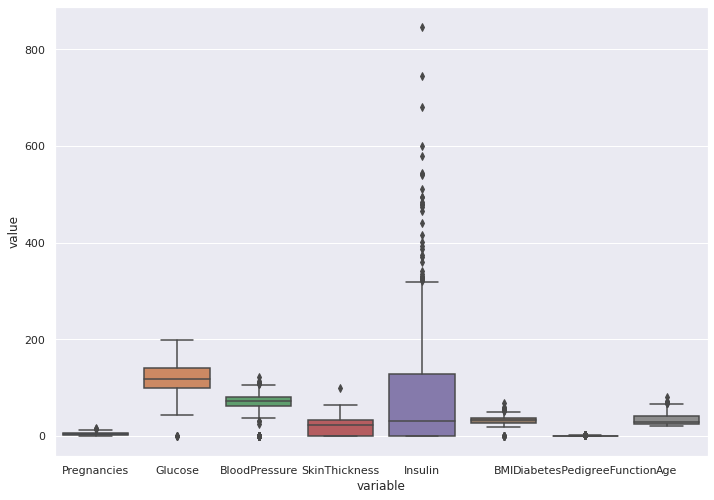

In [22]:
sns.boxplot(x="variable", y="value", data=pd.melt(data.drop(columns=['Outcome'])))

In [ ]:
### Box plot shows a lot of variables outside of IQR, identifying and removing them
# column_names  = list(data.columns)[:-1]
# for column_name in column_names:
#     data = remove_outliers(data, column_name)

In [23]:
data.shape

(768, 9)

In [24]:
X = data[list(data.columns)[:-1]]
Y = data['Outcome']
print(X.shape)
print(Y.shape)

(768, 8)
(768,)


0    500
1    268
Name: Outcome, dtype: int64


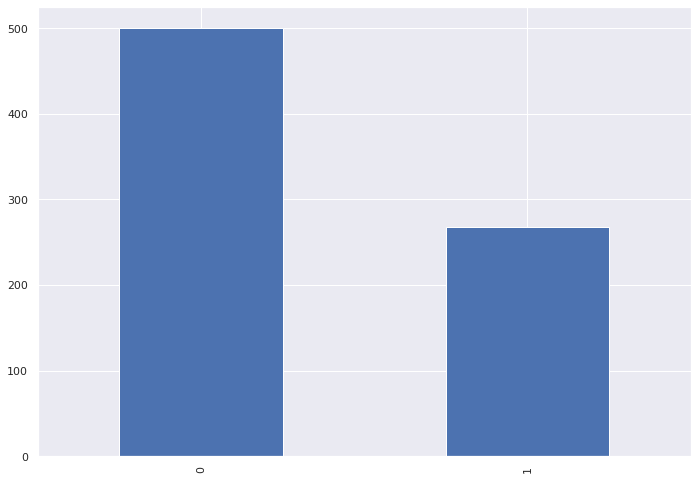

In [25]:
Y.value_counts().plot(kind = 'bar')
print(Y.value_counts())

In [26]:
# data split 60% train 20 % validation 20% test
X_train, Y_train, X_test, Y_test, X_valid, Y_valid = split_data(X, Y, test_size= 0.2, valid_size=0.2,
                                                                seed = 29)
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_valid.shape)

(491, 8) (491,)
(123, 8) (123,)
(154, 8) (123,)


In [ ]:
# # min max scaling, fitting a scaler on X_train and using the same scaler to tranform test, to avoid data leakage
# X_train, scaler = scale_data(X_train)
# X_test = scaler.fit_transform(X_test)
# X_valid = scaler.fit_transform(X_valid)
# print(X_train.shape, Y_train.shape)
# print(X_valid.shape, Y_valid.shape)
# print(X_test.shape, Y_valid.shape)

In [28]:
# standardise to standardise the data using sklearns function X_train and using the same standrdiser to tranform test, to avoid data leakage
X_train, std_izer = standardize(X_train)
X_test = std_izer.fit_transform(X_test)
X_valid = std_izer.fit_transform(X_valid)
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_valid.shape)

(491, 8) (491,)
(123, 8) (123,)
(154, 8) (123,)


In [29]:
# Reshaping data with respect to the need of the algorithm
X_train, X_valid, X_test = np.array(X_train).T, np.array(X_valid).T, np.array(X_test).T
Y_train, Y_valid, Y_test = np.array(Y_train).reshape(1, -1), np.array(Y_valid).reshape(1, -1), np.array(Y_test).reshape(1, -1)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(8, 491)
(8, 154)
(8, 123)


In [30]:
# Initializing w and b :
# Here w is initialised using randomly picked values from a normal distribution
# whose mean is 0 and std is 2
np.random.seed(42)
w = np.random.normal(0, 2,(X_train.shape[0],1))
b = 0

In [31]:
# training  for 50000 epochs with a learning rate of 0.1
total_epochs = 50000
learning_rate = 0.1
costs = []
costs_validation = []
for i in range(total_epochs):
    w,b, cost_this_epoch, loss_valid = run_log_regression(X_train, Y_train, w, b, X_valid, Y_valid,learning_rate, threshold = 0.5)
    costs.append(cost_this_epoch)
    costs_validation.append(loss_valid)

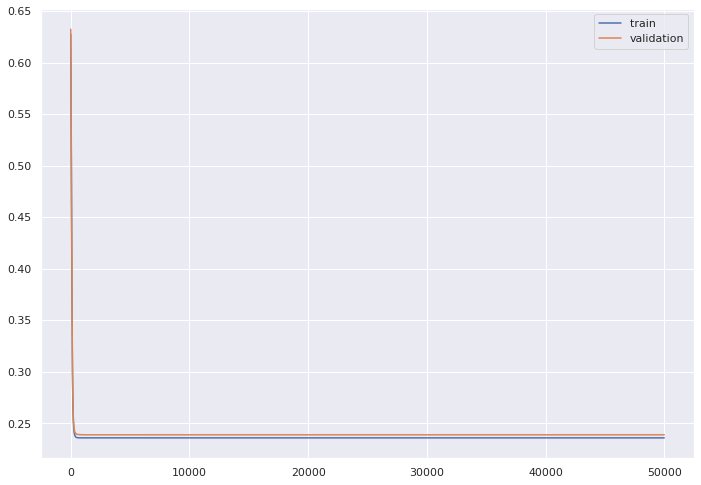

In [32]:
# plotting losses
plt.plot(costs, label = 'train ')
plt.plot(costs_validation, label = 'validation')
plt.legend(loc = "upper right")
plt.show()

### Printing reports

In [33]:
preds_train, prob_train = get_predictions(w, b, X_train, threshold = 0.5)
print('Train report')
print(classification_report(Y_train.T, preds_train))
preds_valid, prob_valid = get_predictions(w, b, X_valid, threshold = 0.5)
print('validation report')
print(classification_report(Y_valid.T, preds_valid))

preds_test, prob_test = get_predictions(w, b, X_test, threshold = 0.5)
print('test report')
print(classification_report(Y_test.T, preds_test))

Train report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       320
           1       0.73      0.57      0.64       171

    accuracy                           0.78       491
   macro avg       0.76      0.73      0.74       491
weighted avg       0.77      0.78      0.77       491

validation report
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        80
           1       0.71      0.51      0.59        43

    accuracy                           0.76       123
   macro avg       0.74      0.70      0.71       123
weighted avg       0.75      0.76      0.74       123

test report
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       100
           1       0.77      0.61      0.68        54

    accuracy                           0.80       154
   macro avg       0.79      0.76      0.77       154
weighted avg       0.80      0.

### Searching for better Parameters

### For Learning Rate  1e-05


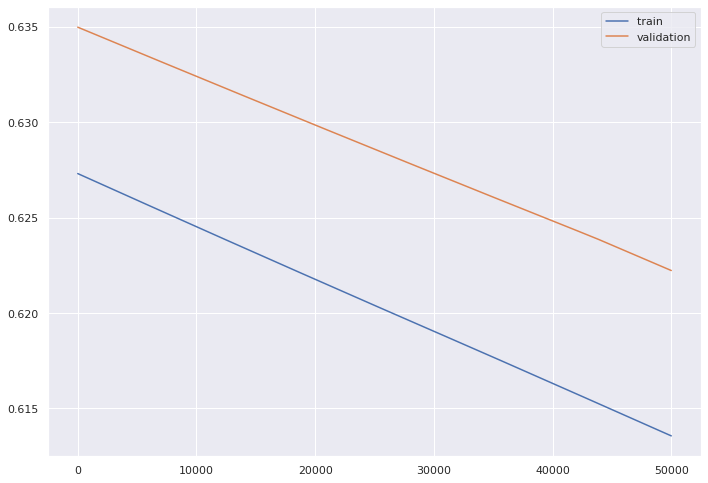

### For Learning Rate  0.0005


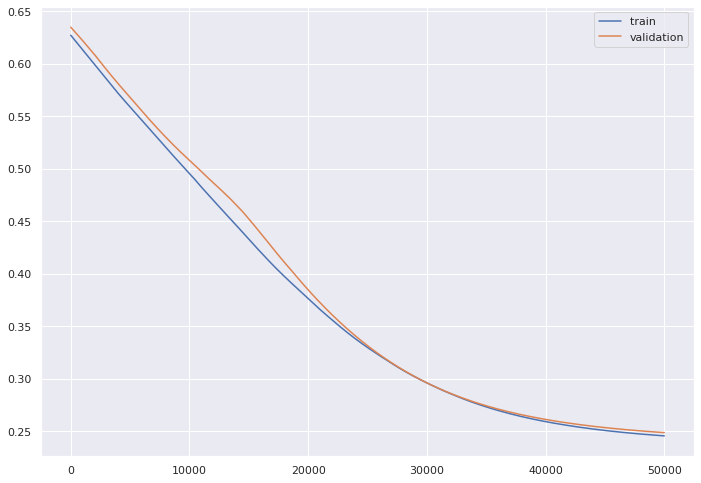

### For Learning Rate  0.0001


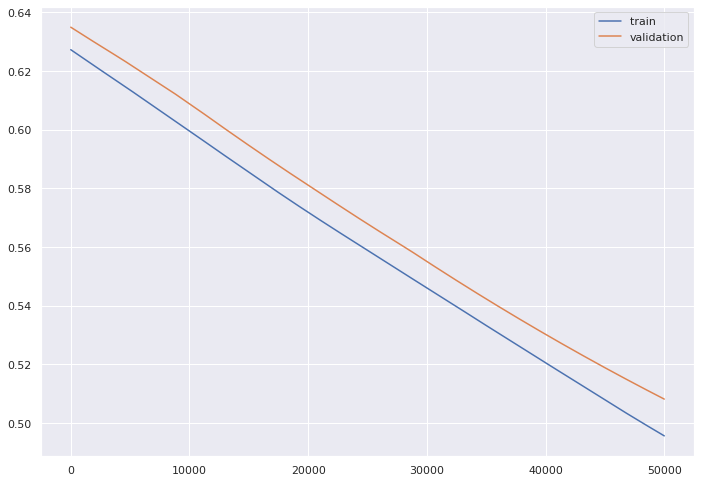

### For Learning Rate  0.001


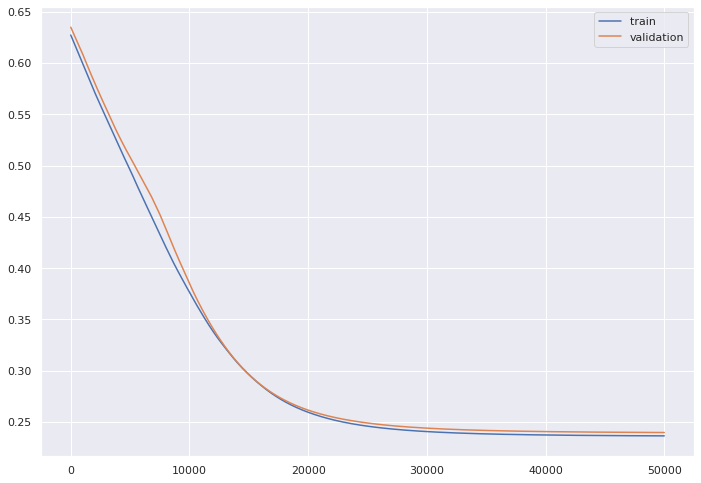

### For Learning Rate  0.005


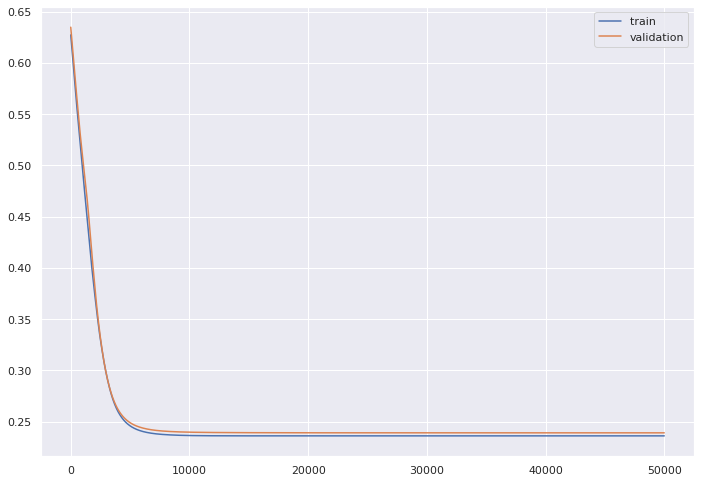

### For Learning Rate  0.01


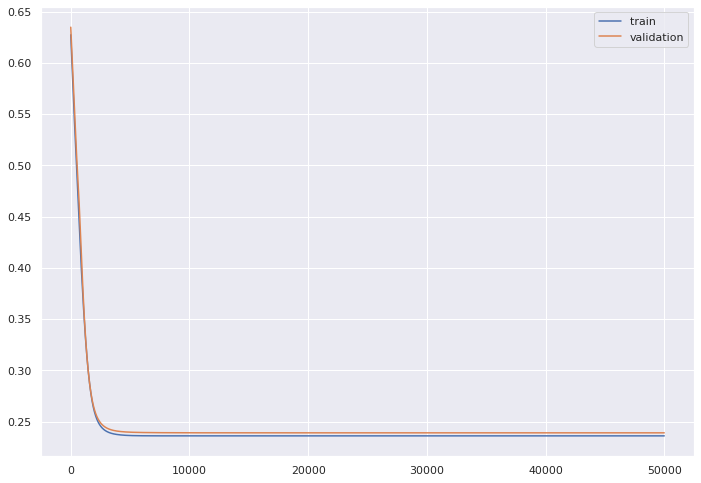

### For Learning Rate  0.05


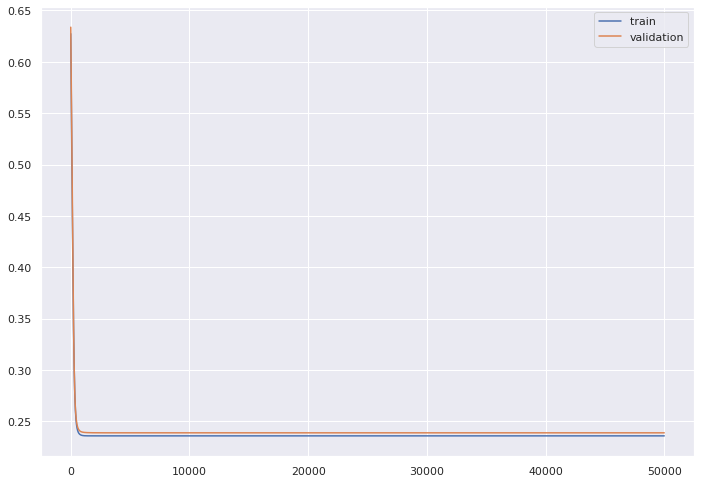

### For Learning Rate  0.1


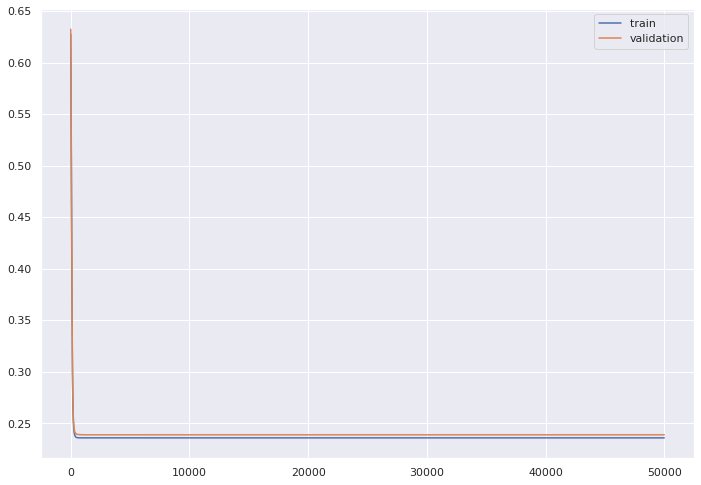

### For Learning Rate  0.5


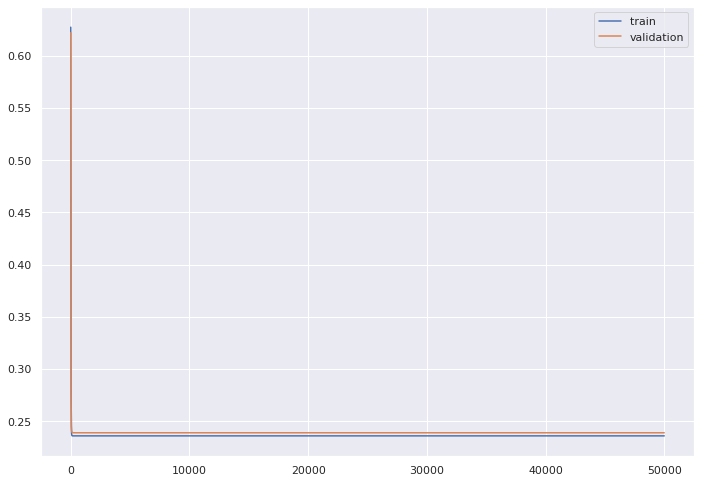

### For Learning Rate  1


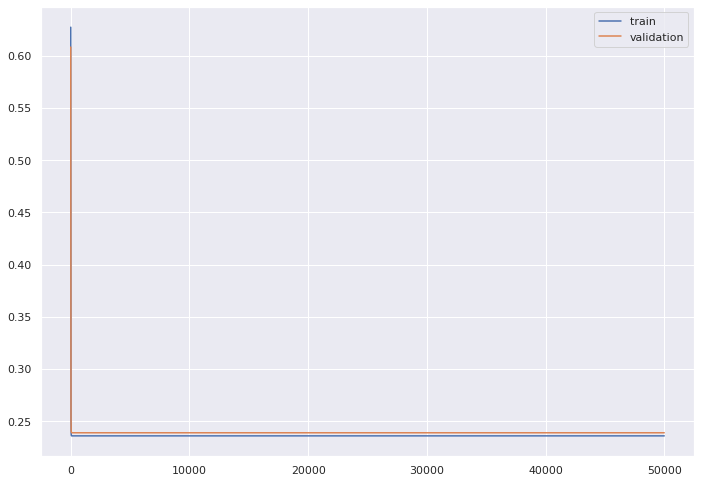

### For Learning Rate  2


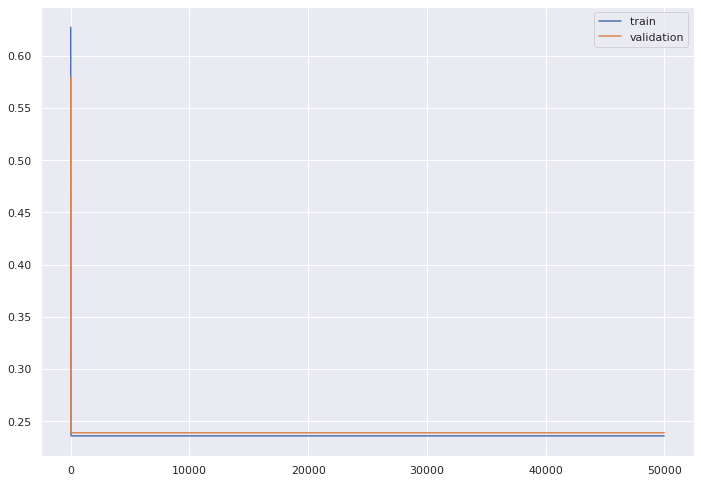

### For Learning Rate  3


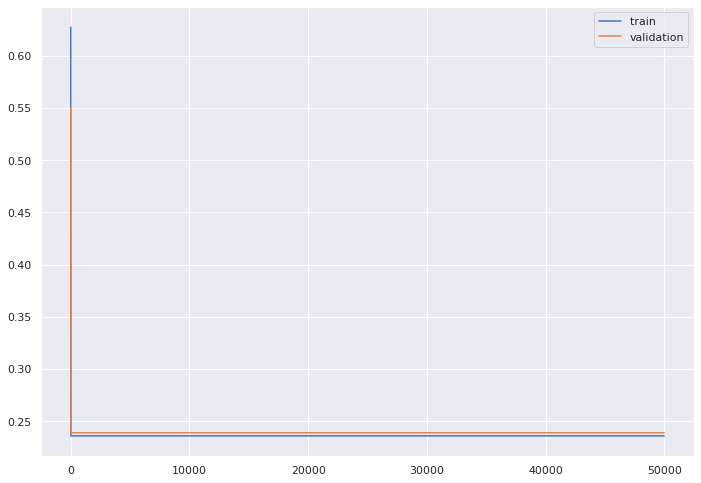

In [34]:
lrs = [0.00001,0.0005, 0.0001, 0.001,0.005, 0.01,0.05, 0.1,0.5, 1, 2, 3]
search_parameters(X_train, Y_train, X_valid, Y_valid, lrs)

#### From the above graphs learning rate 0.01 seems optimum and also it coverges after 10000 epochs.
#### so fixing lr = 0.01 and number of epochs as 10000


In [35]:
# Initializing w and b :
# Here w is initialised using randomly picked values from a normal distribution
# whose mean is 0 and std is 2
np.random.seed(42)
w = np.random.normal(0, 2,(X_train.shape[0],1))
b = 0

In [36]:
# training  for 10000 epochs with a learning rate of 0.01
total_epochs = 10000
learning_rate = 0.01
costs = []
costs_validation = []
for i in range(total_epochs):
    w,b, cost_this_epoch, loss_valid = run_log_regression(X_train, Y_train, w, b, X_valid, Y_valid,learning_rate, threshold = 0.5)
    costs.append(cost_this_epoch)
    costs_validation.append(loss_valid)

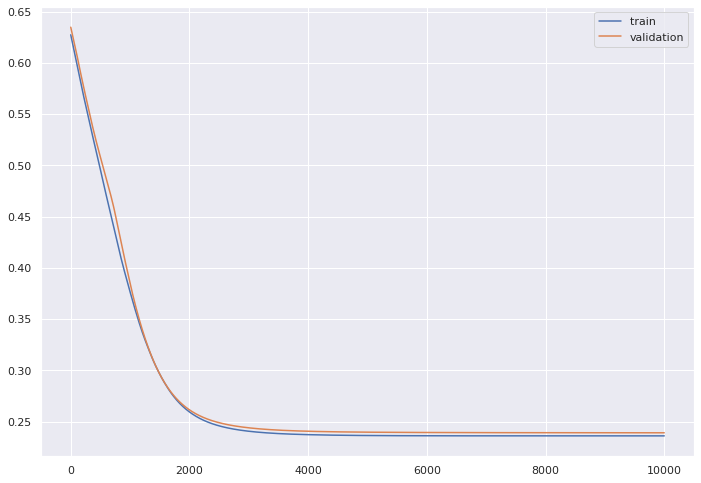

In [37]:
# plotting losses
plt.plot(costs, label = 'train ')
plt.plot(costs_validation, label = 'validation')
plt.legend(loc = "upper right")
plt.show()

### Printing reports

In [38]:
preds_train, prob_train = get_predictions(w, b, X_train, threshold = 0.5)
print('Train report')
print(classification_report(Y_train.T, preds_train))
preds_valid, prob_valid = get_predictions(w, b, X_valid, threshold = 0.5)
print('validation report')
print(classification_report(Y_valid.T, preds_valid))

preds_test, prob_test = get_predictions(w, b, X_test, threshold = 0.5)
print('test report')
print(classification_report(Y_test.T, preds_test))

Train report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       320
           1       0.73      0.57      0.64       171

    accuracy                           0.78       491
   macro avg       0.76      0.73      0.74       491
weighted avg       0.77      0.78      0.77       491

validation report
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        80
           1       0.71      0.51      0.59        43

    accuracy                           0.76       123
   macro avg       0.74      0.70      0.71       123
weighted avg       0.75      0.76      0.74       123

test report
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       100
           1       0.77      0.61      0.68        54

    accuracy                           0.80       154
   macro avg       0.79      0.76      0.77       154
weighted avg       0.80      0.

#### Working on next things

### Optimum threshold
##### Till now threshold used for 0.5, but since the data set is unbalanced,
##### using validation prediction to estimate optimal threshold with roc -auc

AUC score across all thresholds is : 0.8328488372093023
Best Threshold=0.328212, G-Mean=0.766


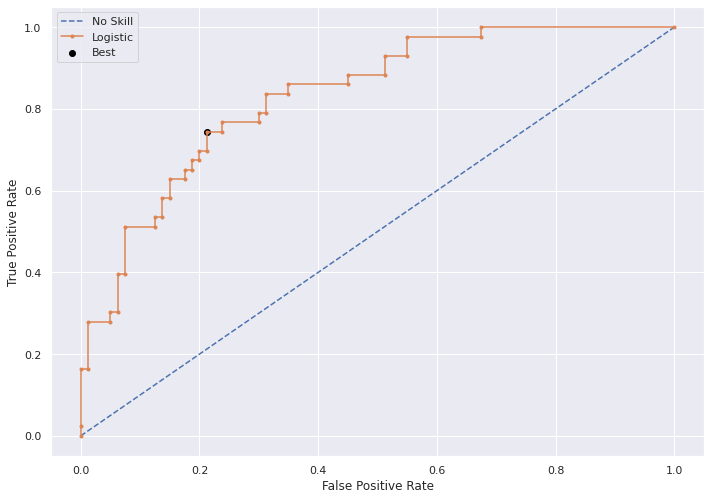

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
# calculate roc curves
auc_score = roc_auc_score(Y_valid[0], prob_valid[0])
print("AUC score across all thresholds is :", auc_score)
fpr, tpr, thresholds = roc_curve(Y_valid[0], prob_valid[0])
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [40]:
preds_train, prob_train = get_predictions(w, b, X_train, threshold = thresholds[ix])
print('Train report')
print(classification_report(Y_train.T, preds_train))
preds_valid, prob_valid = get_predictions(w, b, X_valid, threshold = thresholds[ix])
print('validation report')
print(classification_report(Y_valid.T, preds_valid))
preds_test, prob_test = get_predictions(w, b, X_test, threshold = thresholds[ix])
print('test report')
print(classification_report(Y_test.T, preds_test))

Train report
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       320
           1       0.63      0.79      0.70       171

    accuracy                           0.77       491
   macro avg       0.75      0.77      0.76       491
weighted avg       0.79      0.77      0.77       491

validation report
              precision    recall  f1-score   support

           0       0.84      0.79      0.81        80
           1       0.65      0.72      0.68        43

    accuracy                           0.76       123
   macro avg       0.74      0.75      0.75       123
weighted avg       0.77      0.76      0.77       123

test report
              precision    recall  f1-score   support

           0       0.87      0.77      0.81       100
           1       0.65      0.78      0.71        54

    accuracy                           0.77       154
   macro avg       0.76      0.77      0.76       154
weighted avg       0.79      0.

# Neural networks

In [41]:
# Create a neural network model without any regularization or drop out
model = create_nn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


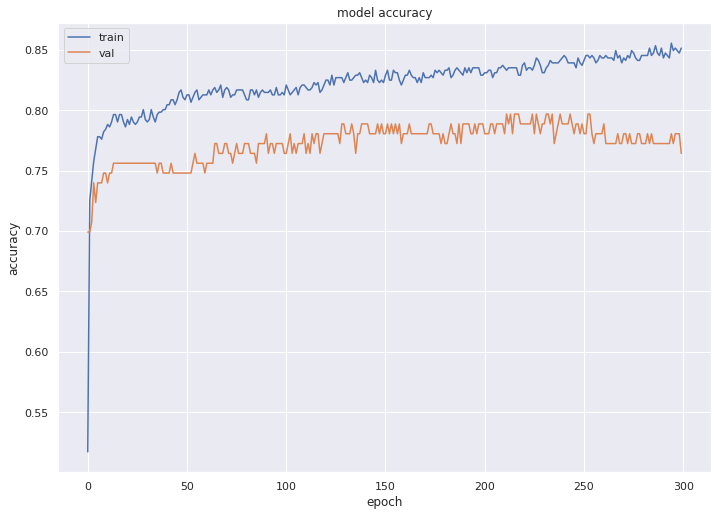

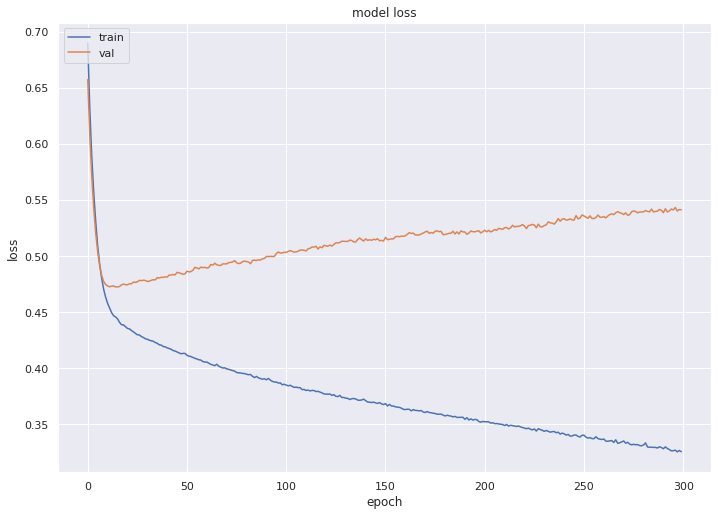

In [42]:
# fit the keras model on the dataset
model = train_nn(model, X_train, X_valid, Y_train, Y_valid, epochs = 300, batch_size = 32)

In [43]:
thresh = 0.5
prob_train = model.predict(X_train.T)
prob_valid = model.predict(X_valid.T)
prob_test = model.predict(X_test.T)
preds_train = [1 if i >= 0.5 else 0 for i in model.predict(X_train.T)]
preds_valid = [1 if i >= 0.5 else 0 for i in model.predict(X_valid.T)]
preds_test = [1 if i >= 0.5 else 0 for i in model.predict(X_test.T)]
print(classification_report(Y_train.T, preds_train))
print(classification_report(Y_valid.T, preds_valid))
print(classification_report(Y_test.T, preds_test))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       320
           1       0.83      0.73      0.78       171

    accuracy                           0.86       491
   macro avg       0.85      0.83      0.84       491
weighted avg       0.85      0.86      0.85       491

              precision    recall  f1-score   support

           0       0.80      0.85      0.82        80
           1       0.68      0.60      0.64        43

    accuracy                           0.76       123
   macro avg       0.74      0.73      0.73       123
weighted avg       0.76      0.76      0.76       123

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.68      0.59      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154



# Regularization

In [44]:
model = create_nn_regularizer(0, 'l1')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


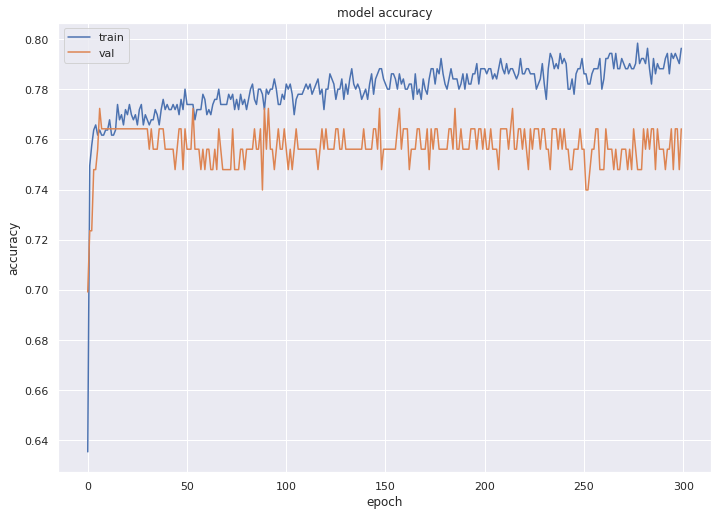

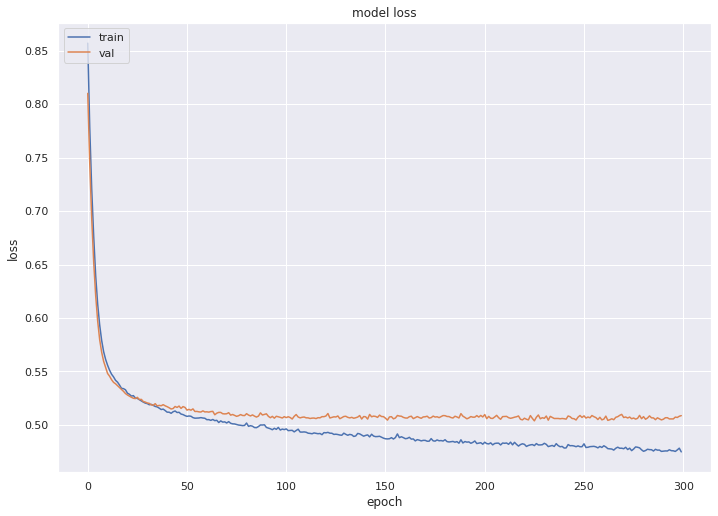

In [45]:
model = train_nn(model, X_train, X_valid, Y_train, Y_valid, epochs = 300, batch_size = 32)

In [46]:
thresh = 0.5
prob_train = model.predict(X_train.T)
prob_valid = model.predict(X_valid.T)
prob_test = model.predict(X_test.T)
preds_train = [1 if i >= 0.5 else 0 for i in model.predict(X_train.T)]
preds_valid = [1 if i >= 0.5 else 0 for i in model.predict(X_valid.T)]
preds_test = [1 if i >= 0.5 else 0 for i in model.predict(X_test.T)]
print(classification_report(Y_train.T, preds_train))
print(classification_report(Y_valid.T, preds_valid))
print(classification_report(Y_test.T, preds_test))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       320
           1       0.77      0.60      0.67       171

    accuracy                           0.80       491
   macro avg       0.79      0.75      0.76       491
weighted avg       0.79      0.80      0.79       491

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        80
           1       0.71      0.56      0.62        43

    accuracy                           0.76       123
   macro avg       0.75      0.72      0.73       123
weighted avg       0.76      0.76      0.76       123

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       100
           1       0.74      0.63      0.68        54

    accuracy                           0.79       154
   macro avg       0.78      0.75      0.76       154
weighted avg       0.79      0.79      0.79       154



In [47]:
## Adding Regularization l2
model = create_nn_regularizer(0,'l2')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


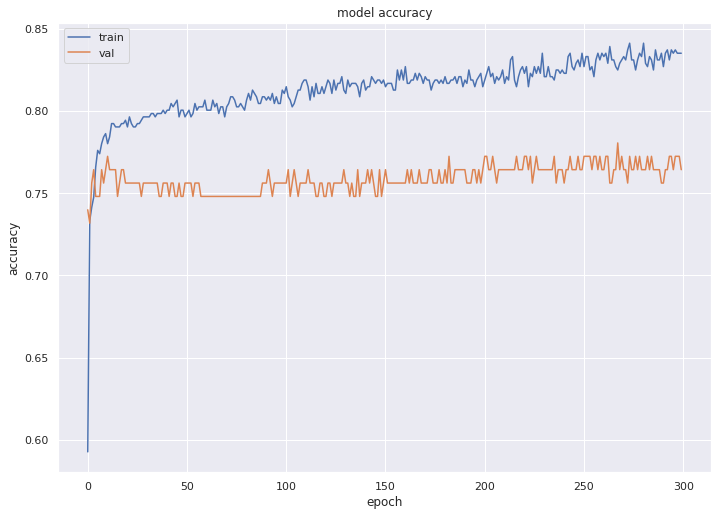

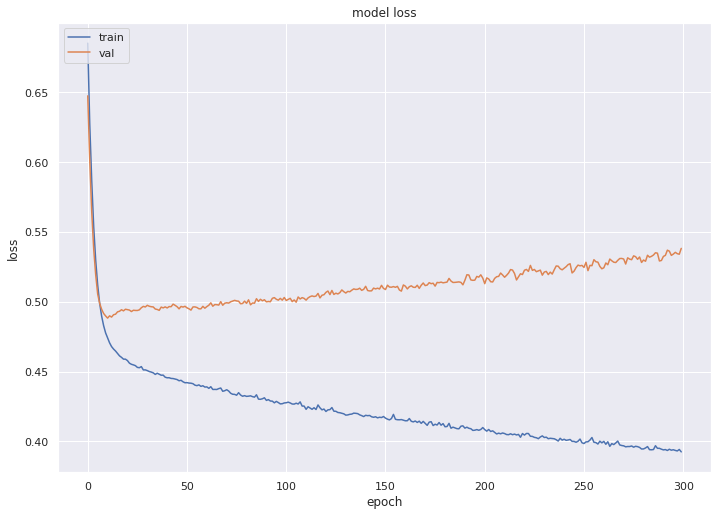

In [48]:
model = train_nn(model, X_train, X_valid, Y_train, Y_valid, epochs = 300, batch_size = 32)

In [49]:
thresh = 0.5
prob_train = model.predict(X_train.T)
prob_valid = model.predict(X_valid.T)
prob_test = model.predict(X_test.T)
preds_train = [1 if i >= 0.5 else 0 for i in model.predict(X_train.T)]
preds_valid = [1 if i >= 0.5 else 0 for i in model.predict(X_valid.T)]
preds_test = [1 if i >= 0.5 else 0 for i in model.predict(X_test.T)]
print(classification_report(Y_train.T, preds_train))
print(classification_report(Y_valid.T, preds_valid))
print(classification_report(Y_test.T, preds_test))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       320
           1       0.82      0.71      0.76       171

    accuracy                           0.84       491
   macro avg       0.84      0.81      0.82       491
weighted avg       0.84      0.84      0.84       491

              precision    recall  f1-score   support

           0       0.79      0.86      0.83        80
           1       0.69      0.58      0.63        43

    accuracy                           0.76       123
   macro avg       0.74      0.72      0.73       123
weighted avg       0.76      0.76      0.76       123

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       100
           1       0.69      0.57      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.72       154
weighted avg       0.75      0.76      0.75       154



## Using Dropout to reduce over fitting

In [50]:
model = create_nn_regularizer(0.2, 'l1')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


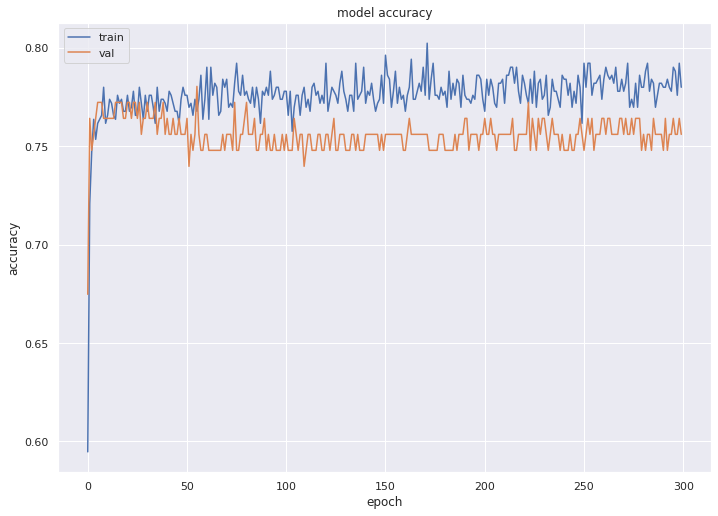

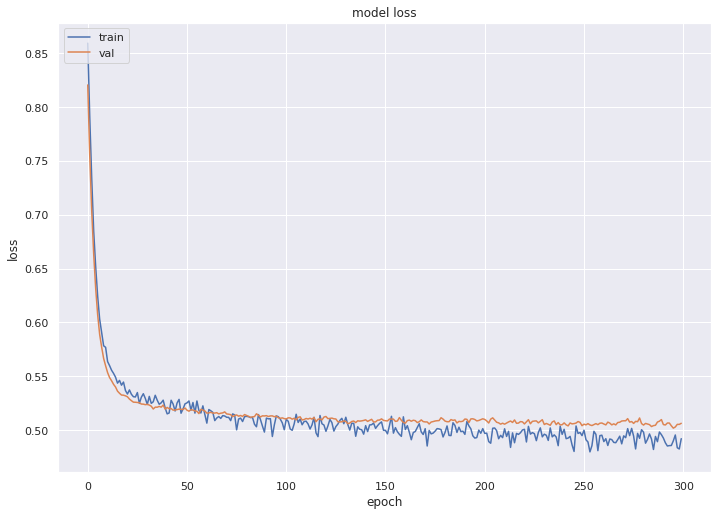

In [51]:
model = train_nn(model, X_train, X_valid, Y_train, Y_valid, epochs = 300, batch_size = 32)

In [52]:
thresh = 0.5
prob_train = model.predict(X_train.T)
prob_valid = model.predict(X_valid.T)
prob_test = model.predict(X_test.T)
preds_train = [1 if i >= 0.5 else 0 for i in model.predict(X_train.T)]
preds_valid = [1 if i >= 0.5 else 0 for i in model.predict(X_valid.T)]
preds_test = [1 if i >= 0.5 else 0 for i in model.predict(X_test.T)]
print(classification_report(Y_train.T, preds_train))
print(classification_report(Y_valid.T, preds_valid))
print(classification_report(Y_test.T, preds_test))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       320
           1       0.74      0.60      0.66       171

    accuracy                           0.79       491
   macro avg       0.77      0.74      0.75       491
weighted avg       0.78      0.79      0.78       491

              precision    recall  f1-score   support

           0       0.78      0.88      0.82        80
           1       0.70      0.53      0.61        43

    accuracy                           0.76       123
   macro avg       0.74      0.70      0.71       123
weighted avg       0.75      0.76      0.75       123

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       100
           1       0.78      0.65      0.71        54

    accuracy                           0.81       154
   macro avg       0.80      0.77      0.78       154
weighted avg       0.81      0.81      0.81       154



AUC score across all thresholds is : 0.8345930232558141
Best Threshold=0.370698, G-Mean=0.772


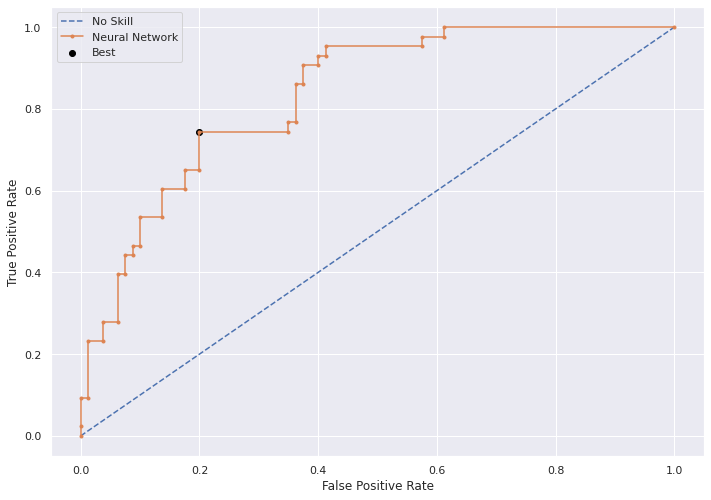

In [53]:
### Threshold optimisation
from sklearn.metrics import roc_curve, roc_auc_score
# calculate roc curves
auc_score = roc_auc_score(Y_valid[0], prob_valid)
print("AUC score across all thresholds is :", auc_score)
fpr, tpr, thresholds = roc_curve(Y_valid[0], prob_valid)
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Neural Network')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [54]:
thresh = thresholds[ix]
prob_train = model.predict(X_train.T)
prob_valid = model.predict(X_valid.T)
prob_test = model.predict(X_test.T)
preds_train = [1 if i >=thresh else 0 for i in model.predict(X_train.T)]
preds_valid = [1 if i >= thresh else 0 for i in model.predict(X_valid.T)]
preds_test = [1 if i >= thresh else 0 for i in model.predict(X_test.T)]
print(classification_report(Y_train.T, preds_train))
print(classification_report(Y_valid.T, preds_valid))
print(classification_report(Y_test.T, preds_test))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       320
           1       0.66      0.77      0.71       171

    accuracy                           0.78       491
   macro avg       0.76      0.78      0.77       491
weighted avg       0.79      0.78      0.78       491

              precision    recall  f1-score   support

           0       0.85      0.80      0.83        80
           1       0.67      0.74      0.70        43

    accuracy                           0.78       123
   macro avg       0.76      0.77      0.76       123
weighted avg       0.79      0.78      0.78       123

              precision    recall  f1-score   support

           0       0.85      0.74      0.79       100
           1       0.61      0.76      0.68        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.77      0.75      0.75       154

